# Signal modelling and source separation - PPV/ARFB models

This notebook trains signal models and performs source separation for multiple signals.

Limitations:
* non-stationary


## Load packages

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using ForneyLab
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using ProgressMeter
using Printf
using HDF5
using Distributions
using StatsBase

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl")
include("../extensions/ARFB.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
ForneyLab.unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]
unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]

unsafeMean (generic function with 1 method)

## Parameters

In [3]:
# signal definition
sound_files = ["../data/airco.wav",          # specify sound sources to model and separate (can be more than 2)
               "../data/whistle.wav"]
fs_desired = 8000                              # specify desired sampling frequency of signals
duration_train = 1                             # specify duration of training signals
duration_sep = 1                               # specify duration of separating signals
normalization_method = "max"                   # specify method to use for normalizing the signals

# save folders
folder_params = "inferred/PPV_model"            # specify folder to save inferred values in (to save time when recomputing)
folder_figures = "figures/PPV_model"            # specify folder to save figures in

# inference and modelling
nr_freqs = 39                                  # order of auto-regressive model
iterations = 5                                 # number of iterations for variational message passing
γ_meas_train = 1e4                             # assumed precision of measurement noise during training
γ_meas_sep = 2e3                               # assumed precision of measurement noise during source separation
;

In [4]:
# auxiliary variables
bufsize = 2*(nr_freqs+1)
stepsize = 1
;

## Load and preprocess data

In [5]:
# create array for time signals
signal = Array{Array{Float64,1},1}(undef, length(sound_files))
signal_sep = Array{Array{Float64,1},1}(undef, length(sound_files))

# load signals, preprocess, crop and save
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration_train)*fs_tmp]
    
    # preprocess signal and save
    signal[k] = preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
        
end

# load signals, preprocess, crop and save
for k = 1:length(sound_files)
    
    # load signal
    signal_sep_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_sep_tmp = Float64.(signal_sep_tmp)
    
    # crop signal
    signal_sep_tmp = signal_sep_tmp[1*fs_tmp+1:(1+duration_sep)*fs_tmp]
    
    # preprocess signal and save
    signal_sep[k] = preprocess(signal_sep_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
        
end

# create mixture signal 
ymix = sum(signal_sep)

# create time axis
t_train = collect(1:length(signal[1]))/fs_desired
t_sep = collect(1:length(ymix))/fs_desired
;

## Visualise signals

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AAA7vRQ+FKaiPmRfsT5wVMU+UDLGPl4H4z75MgE/VkQQP7gEGT8XsAk/OKnsPlxJ2T5dhs0+CD3kPk1x3z5FZNE+4wmePkMInT5s2p8+X0bAPs/imT4heIw+qHCCPsyHCT7BhUo+s2IXPtPtRr2eYWm+viCGvvJSHb4b0gU9oCjNPeZ08rx8WQC+t1ZQvlRZ7b1zGmW94J8qvrqROb7yWZy+5anivlrN/75MHO2+z/qZvorzpL4MH4S+BgOyvlMQxr4QEtO+P5AFv8LpD7+kHAu/+8YUvwy4AL+Euce+Nfh0vuFagr7ziae+xh2UvsQTgr5vIVm+moyuvUabT71lsX68ATkOvlwJpL6qOKy+xFRTvgDTBL3l34k9kRCPOyvwt732no+9IrLfPZathj4UbGw+7SBFPm1lTj1asXg9KwahPl8eBT+dlRA/QwXiPkDyoz6yZMw+9/IOP8y/NT8NlTE/S14VPzVoJj+WsTE/DNZFPzfCMj+AJQ8/QnUEPyTN+T6p7f4+WCn3Pt8gxT6AUI4+DcWfPiq4zj5oIq8++MELPlZGC70eth+9okE2PXz6/T2s3ss7sJEzvoSeyL7dXOe+hAy1vj5FU75VnIG+5Oa5vuBv3r4vYva+XOn+vtHe7L4ZwvC+FyLhvhRMzL71k8K+djm7vlLuv761s4S+AruKvqLPir4I5W2+ueKFviFGib4aAmO+t6iVvh66jL5q7Yi+LByFvvUWQr4fpCC+gbSovr1WEb8xiSO/b3cRv8BY2b5lSYq+D6ZfvmJihL4AEdG+9J7Lvrm+x77y4bG+0P9jvpgnFb6w/S6+M2zFvcmMl71ibYq977zEPB4HXz4vnbc+NZjWPmiD0D7q2aE+GAStPtZ83z4oSxU/Is01P/CgND8Evhc/R1YJP51IDT8XyDc/dadRPxy2Mj9kfgs/0iLAPuDfsT4sGsI+m5YRP85ORz8cPU4/Cr84P465ET/H9Ag/q7btPuGOAT8s+ds+sBWhPnJUdT7Vt04+y79BPrXK+z0iW2A8jsnNvf76fb7qV36+mBmEvur9lb6BGs6+8+0Tv55tMb8bKyi/Gw0RvzHfA79hKxa/rVAwv7KxSr8lBjy/j0Ikv7hfLL9mAjO/qGcbv4LID7/RZu++OF/zvgdy6r6Xyea+rdi+vtJ5m76BsKC+rciPvgBpaL78nku+EAtAvtb9Nr4R1DO+nnLOvbG7Y77NQYa9QfarPTB0tz2KNjU7T00EvovLHL17uIm91woPPR4ddT5A+Wg+Vds0PYNIS7wKdo89bw2NPrSD1j6eHAI/HDLqPjR/uD7Je8w+xhTfPpp87T5AQeY+6a/aPjh6wT4TtJo+TlqPPk4+wT4MIss+5VbrPh9/3j5YrcM+NF6UPsVBPT5Y5Lw9Xe9iPlinjj67n8g+N0inPlU6TT6QkOE9aA7MPdhojz6eU78+d17OPqBVpD46jDU9qvIwPV7AtD0ySdE9vGVSPZ3g/bxPNVW9RaJ/vRh0lTtdCaQ8KTVlvfYNL74wIme+yKFtvuHJKb7Pw4O+1iAEvzruDr/8bSS/T9wSv5rPBL93PRq/GLtCv+3IXL9i8Ue/vD85v2GgG79dTQi/qKIgv1OlGL/DOQS/wOyMvktOV76K9Fa+I2QyvhDk6734J048RSO9PdqR2T2QlPY9izlHPtVApT5RK6o+UgOAPh5bJD7tEY09DK7HPWwOuD5FKMs+vf7KPjiojT6i+pI9W3RjPeyixz2IH6Y+07yoPkbVhz4dwW0+jF2fPuisqD4HNtg+p7HhPmIT4D7Te6M+gyk+PmZXqj5E8tE+NcnuPgqz2j7gA7E+0OmFPkXFiT7pkJ4+3xKMPrZ8ez4f+Rw+PikOPsqVKT6oRgc+w/sZPoPTGD7mQNM94y+8PRRpQj33p4s9QwcCPHA42L1FhBS+SIvFvWWOnr2vtga9U4J9vMY5Hb77q2S+lw+HvnPdVb7uQue9zRVpvtkXxb48ovG+pS/+vgrIFL/C0wq/90AOv7BwDL/nHxG/0LkjvyQMPb8KFm2/Q/9/vz7lar+ykVq/0kM4v5KqKr828yG/aAUfv369Bb8Zmtu+dBWhvjy5Mr5UKQO+1DasvVCZED4kuYo+8MLkPhnZCj8SNOk+9fe9Pi8JyT4h7d8+8kIKP5WNMD+B1C4/bcUaP4TS/T76pf8+MaUkP4eHKj+flRs/iKQFP+Y27T4qCgo/Z3QaP1d5ET9k+QE/z8rHPrdTxz7YS7s+LtHVPsObzD5mQa8+MACZPmTwtT4ZX8A+NGy1Po5uZT7zNV0+KGp4Pl63mT48kLM+VuKKPq0wHj7BOQG9vE/UvUeUoL1QDUW+oSp6vuXcnb4n3K++IH9tvum3cL7vY6O+SWkBv5+CIb8EXBS/i+MJv7kQFb9CNiu/jGI9v8PAJr87IAW/swWnvpIQnL7yMOe+4Okfv9wAJr+ntAi/lt7Evv6ytL5eW5y+SjCxvqd5pr6Uj0y+ygNKvj/5UL65JRy+2CTjvQexib0SnGq9g03WvawBcr4MF0W+F/HOvFszJj5kU1c+i7oBPiwH0j2jVvI89awrPudPFz7Zgn49kNpRPQQhoT3Q3lo+FU6gPmr4rT5k1KI+Psq5Pm9c3T7vxww/IhAqP0uQLT/ewQc/9RL+Pr+f+T4p9uY+pxEZP9Tq+j7sN/s+14kRP9RQHD9Auw8/uAIZPxAAJz8Zzw4/fj0AP1mR1T65DaE+7NimPiQGxj6u37Q+JEVIPuBhvj2MGzW9cqgOvgFiIr53B5K++gmDvncMpr54UrG+LqjtviKQJr+cIzS/aVwcvz3fC7+6ZRa/bjw6v56gbr/Qg32/xXhzv+WqSb/P5ha/NXwQv8gyB79ncAG/7EQEv/ZU6r49yNu+/mr2vrnGuL6QeYy+G+D2vdhqkb172QO+s3Fqvgthfr6XlAC+Pfm7PdQ/Jj2O6GO9PljdvZ6qO72P6q49yPd0Pk6YeT5uvEY+FCY4PhtLhD4q6Zs+25HuPk5GAz+ll+I+a7rVPrOo4j6TruA+nCOgPuBsVT40b909kgmFPiHU1z5vygs/NermPnuNlz5U3x8+VlFuPqHQ1T5PE/w+gT8APwHTAz84hf0+A+UkP7qAIT+w/iM/6nkAPyCIwz7LCac+RKHSPnTTCD/TQRo/AwUAP0vmpz69EDk+2rcWPpAcND7YaTk+IzPFPdNgPr2SkMe9fu4WvpYvh7tiif08YjW7O4iZI74C3o6+6BTcviemFb9vrye/yKQpv+ETJr9ZDy+/V3Udv4hDGL/oIyW/0Uwbv89cGr9p5Sy/4MU1v7+iNb+3dEG/W0Vjv3+5WL+ybz6/LB47v0VTH78imwa/Qg79vosI0r79guK+S4jwvj7wsb5mva2+es6QvkFVab7T6Fa+6rmvvSOnMD3TgBQ+UluIPkaFij6hlaY+msqaPi0VlD6Xebk+FOvPPl/ltj5OJ9A+39yzPr7Grz4K7OE+br/ZPglr4D4tAsc+hw6bPhvgOj44Ewk+RX1qPdqrbj49L6U+yVnbPuHFqD7hTIA+OIygPs7P0T597cc+wGKRPifQ+D26XgM9KSCUPvfrAT+8jyM/0CcOP7RZpz6KivY9d42NPZ5FJz6tyrE+tYKpPqy6Pz4JcrC9Y41EvuMGyr0ZpbM9ZaKnPS3pib2cryu+rLqDvj6Jr75Opr6+3/XXvqpLCL+hYxa/mNwCv6qKAL82tdm+Nd3gvt4g+b526fW+CW8IvzdtCr95wgK/SqICvyM0y75jbI6+mJthvvXSM778O2W+Jn06vp2VXD1xn6E+zmDlPnzjoD4wqws+p0amPMewHz0p0FU+dby0PuFBwj6UVbI+yVIxPi5AEj7gXJg+CiLWPkEf6z4Ik

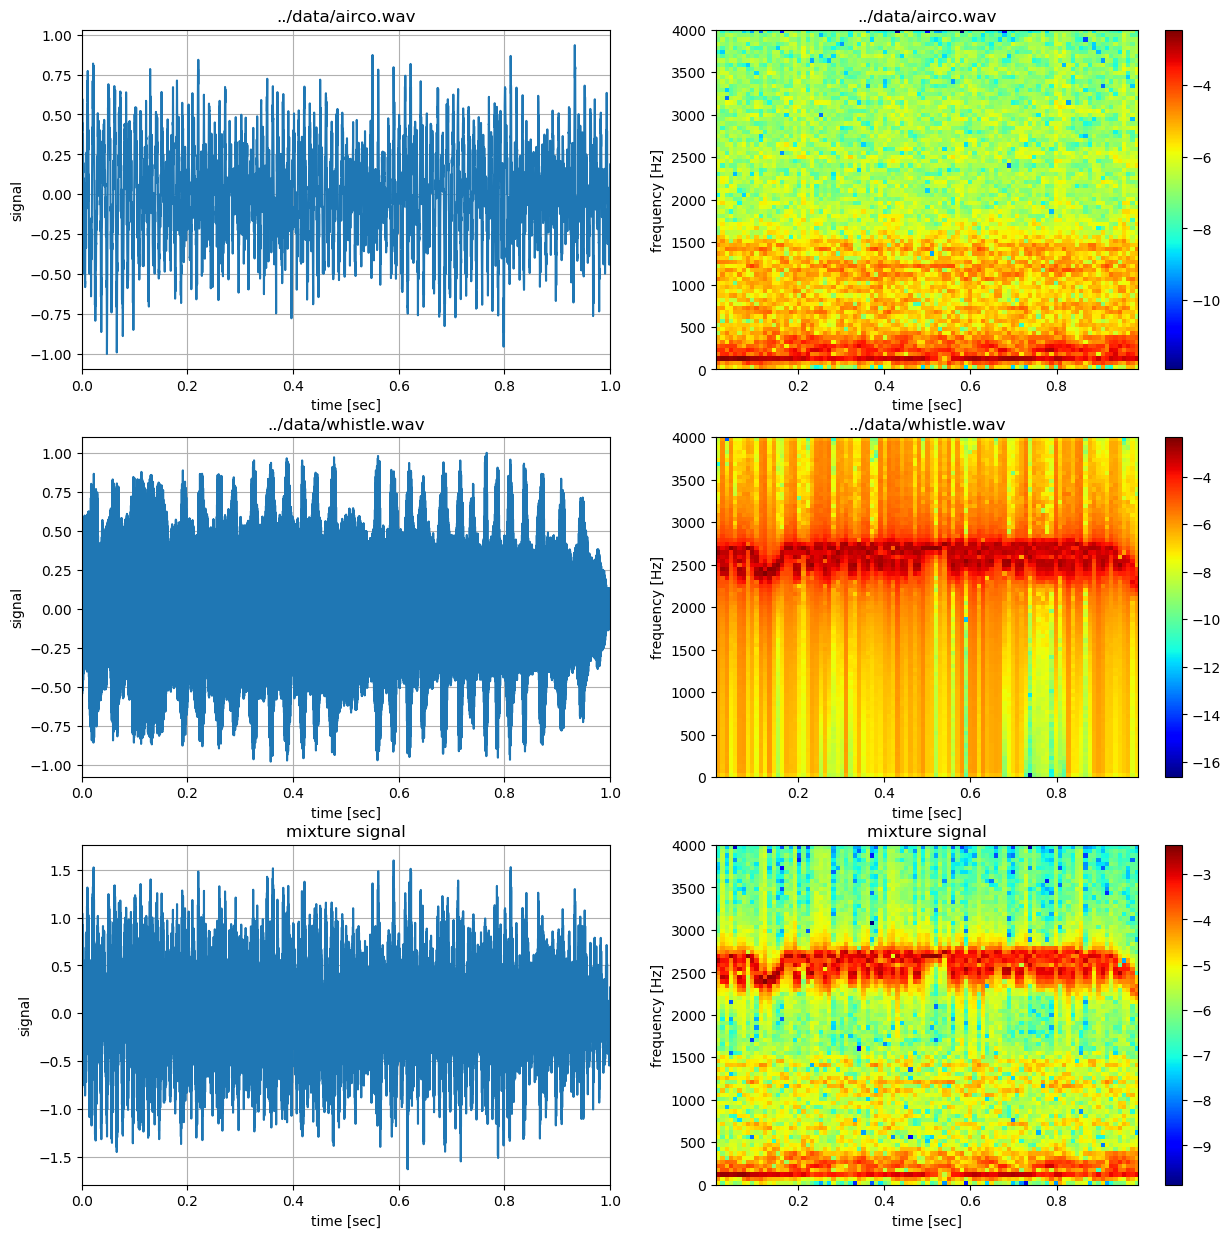

In [6]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files)+1, figsize=(15, 5*(length(sound_files)+1)))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t_train, signal[k]), ax[k,1].set_xlim([0, duration_train]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k])
    
    # plot spectrogram of signal
    plot_spectrogram(spectrogram(signal[k], 160, 80, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true), ax[k,2].set_title(sound_files[k])

end

# finally add mixture signals
ax[end,1].plot(t_sep, ymix), ax[end,1].set_xlim([0, duration_sep]), ax[end,1].set_xlabel("time [sec]"), ax[end,1].set_ylabel("signal"), ax[end,1].grid(), ax[end,1].set_title("mixture signal")
plot_spectrogram(spectrogram(ymix, 160, 80, fs=fs_desired), fs_desired, ax=ax[end,2], colorbar=true), ax[end,2].set_title("mixture signal")

# create audioplayers
audioplayers(signal..., ymix, fs=fs_desired)
;

## Define signal model

In [7]:
# create expression that can draw an entire graph in a factor graph statement
function signal_model(k, nr_comp, bufsize)
    
    # wrap code into an expression to execute later on in a factor graph type to allow for modularity
    model = quote
        
        # create dictionary for variables
        if !@isdefined vars
            vars = Dict()
        end
        
        # PPV node
        @RV [id=pad(:smin,$k)] vars[pad(:smin,$k)] ~ GaussianMeanVariance(placeholder(pad(:μ_smin,$k), dims=($nr_comp,)), placeholder(pad(:Σ_smin,$k),dims=($nr_comp, $nr_comp)))
        @RV [id=pad(:ρ,$k)] vars[pad(:ρ,$k)] ~ GaussianMeanVariance(placeholder(pad(:μ_ρ,$k), dims=($nr_comp,)), placeholder(pad(:Σ_ρ,$k),dims=($nr_comp, $nr_comp)))
        @RV [id=pad(:w,$k)] vars[pad(:w,$k)] ~ ForneyLab.Wishart(placeholder(pad(:v_w,$k), dims=($nr_comp,$nr_comp)), placeholder(pad(:nu_w,$k)))
        @RV [id=pad(:s,$k)] vars[pad(:s,$k)] ~ AutoregressiveFilterbank(vars[pad(:smin,$k)], vars[pad(:ρ,$k)], vars[pad(:w,$k)])
       
        # probabilistic Fourier
        @RV vars[pad(:x,$k)] = placeholder(pad(:C,$k), dims=($bufsize, $nr_comp))*vars[pad(:s,$k)]

        # create recognition factor
        q = ForneyLab.PosteriorFactorization(vars[pad(:smin,$k)], vars[pad(:s,$k)], vars[pad(:ρ,$k)], vars[pad(:w,$k)], ids=[pad(:smin,$k), pad(:s,$k), pad(:ρ,$k), pad(:w,$k)])
    
    # end expression
    end 
       
    # return expression
    return model
    
end
;

## Train models or load parameters

In [8]:
function train_model(k, model, signal, t, nr_freqs, bufsize, iterations, γ_train)
    
    # pretrain model parameters
    ω, ρ, σ2 = pretrain_ARFB(signal, nr_freqs)
    
    # create factor graph
    FactorGraph()
    
    # create model
    eval(model)
    
    # add observation noise
    @RV y ~ GaussianMeanPrecision(vars[pad(:x,k)], placeholder(:γ_meas, dims=(bufsize,bufsize)))
    
    # create output samples
    placeholder(y, :y, dims=(bufsize,))
    
    # create algorithm
    algo = variationalAlgorithm(q)
    source_code = compatibility_fix(algorithmSourceCode(algo))
    eval(Meta.parse(source_code))
    
    f = ω/2/pi/(t[2]-t[1])
        
    # create arrays for current estimates
    data = Dict()
    data[:γ_meas] = γ_train*Ic(bufsize)

    # get dictionary of currently inferred values 
    vals = Dict()
    vals[pad(:f,k)] = f;
    vals[pad(:μ_smin,k)] = zeros(2*nr_freqs)
    vals[pad(:Σ_smin,k)] = 100*Ic(2*nr_freqs)
    vals[pad(:μ_ρ,k)] = repeat(ρ, inner=2)
    vals[pad(:Σ_ρ,k)] = 0.001*diagm(ones(2*nr_freqs))
    vals[pad(:v_w,k)] = diagm(1 ./repeat(σ2, inner=2))/(2*nr_freqs)
    vals[pad(:nu_w,k)] = 2*nr_freqs    
    
    # get signals
    signal_t = [signal[k:k+bufsize-1] for k=1:length(signal)-bufsize+1]
    t_t = [t[k:k+bufsize-1] for k=1:length(t)-bufsize+1]

    p = Progress(length(signal_t))
    
    # loop through data
    for n = 1:length(signal_t)

       
        # fill data dictionary
        data = merge(data, vals, 
                Dict(:y => signal_t[n].-mean(signal_t[n]), pad(:C,k) => reshape([cos.(2*pi*f*t_t[n]') sin.(2*pi*f*t_t[n]')]', bufsize, 2*nr_freqs)))

        # create marginals dictionary
        marginals = Dict()
        marginals[pad(:smin,k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=vals[pad(:μ_smin, k)], v=vals[pad(:Σ_smin, k)])
        marginals[pad(:ρ,k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=vals[pad(:μ_ρ, k)], v=vals[pad(:Σ_ρ, k)])
        marginals[pad(:w,k)] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=vals[pad(:v_w, k)], nu=vals[pad(:nu_w, k)])
    
        
        # perform updates
        for _ = 1:iterations

            # perform inference
            marginals = Base.invokelatest(getfield(Main, Symbol("steps_"*string(k,pad=2)*"!")), data, marginals)
            marginals = Base.invokelatest(getfield(Main, Symbol("stepρ_"*string(k,pad=2)*"!")), data, marginals)
            marginals = Base.invokelatest(getfield(Main, Symbol("stepw_"*string(k,pad=2)*"!")), data, marginals)
            marginals = Base.invokelatest(getfield(Main, Symbol("stepsmin_"*string(k,pad=2)*"!")), data, marginals)

        end
        
        # get new values
        vals[pad(:μ_ρ, k)] = ForneyLab.unsafeMean(marginals[pad(:ρ, k)])
        vals[pad(:Σ_ρ, k)] = ForneyLab.unsafeCov(marginals[pad(:ρ, k)])
        vals[pad(:μ_smin, k)] = ForneyLab.unsafeMean(marginals[pad(:s, k)])
        vals[pad(:Σ_smin, k)] = ForneyLab.unsafeCov(marginals[pad(:s, k)])
        vals[pad(:v_w, k)] = marginals[pad(:w,k)].params[:v]
        vals[pad(:nu_w, k)] = marginals[pad(:w,k)].params[:nu]
    
        next!(p)
    end

    return vals
    
end
;

In [9]:
# create placeholder for parameters
params = Array{Dict, 1}(undef, length(sound_files))

# loop through signals
@showprogress for k = 1:length(sound_files)
    
    # check whether parameters have already been inferred
    filename = folder_params*"/PPV_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", γ_meas_train)*".h5"
    if isfile(filename)
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        println("For signal "*string(k)*" the parameters have been found and loaded.")
        
    else
        
        # train models and save parameters
        println("For signal "*string(k)*" the parameters have not been found and are now being trained...")
        
        # load graph
        model = signal_model(k, 2*nr_freqs, bufsize)

        # train model
        vals = train_model(k, model, signal[k], t_train, nr_freqs, bufsize, iterations, γ_meas_train)
        
        # save parameters
        h5open(filename, "w") do file
            write(file, "parameters/v_w", vals[pad(:v_w, k)])
            write(file, "parameters/nu_w", vals[pad(:nu_w, k)]) 
            write(file, "parameters/mean_rho", vals[pad(:μ_ρ, k)]) 
            write(file, "parameters/cov_rho", vals[pad(:Σ_ρ, k)]) 
            write(file, "parameters/freqs", vals[pad(:f,k)])
        end
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        
        # return statement of completion
        println("For signal "*string(k)*" the parameters have now been trained and saved for later use.")
        
    end
    
end

For signal 1 the parameters have been found and loaded.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


For signal 2 the parameters have been found and loaded.


In [10]:
function convert_parameters(params)
    params_new = Dict()
    for k=1:length(params)
        params_new[pad(:v_w, k)] = params[k]["v_w"]
        params_new[pad(:nu_w, k)] = params[k]["nu_w"]
        params_new[pad(:μ_ρ, k)] = params[k]["mean_rho"]
        params_new[pad(:Σ_ρ, k)] = params[k]["cov_rho"]
        params_new[pad(:f,k)] = params[k]["freqs"]
    end
    return params_new
end
;

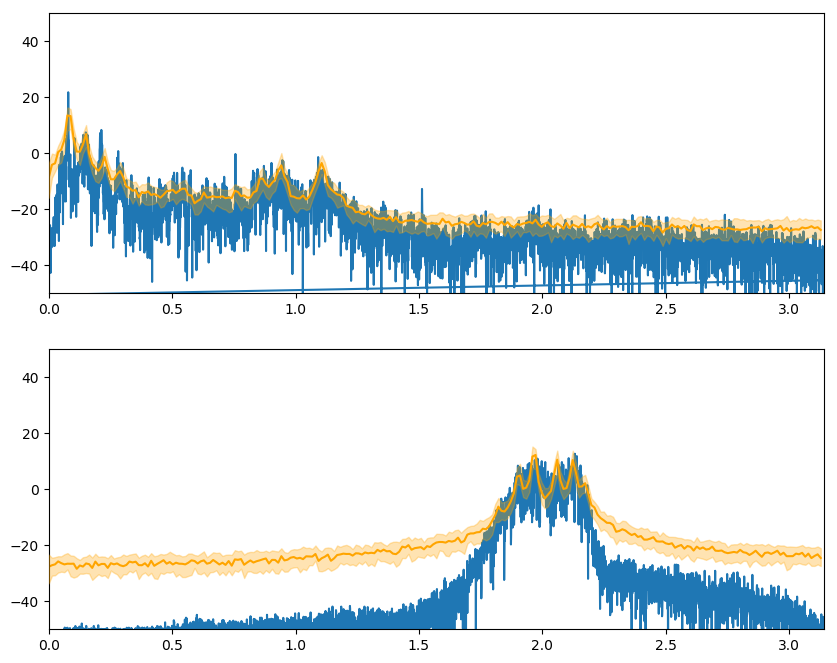

In [11]:
# create figure
_, ax = plt.subplots(nrows = length(sound_files), figsize=(10,4*length(sound_files)))

paramsc = convert_parameters(params)

fs = fs_desired

# loop through signal models
for ki = 1:length(sound_files)
    # generation:
    Ni = 500 # (nr samples + frequency resolution)
    Mi = 100 # nr of iterations

    # get parameters ForneyLab.unsafeMean(marginals[:θ])
    μ_θi, Σ_θi = paramsc[pad(:μ_ρ,ki)], paramsc[pad(:Σ_ρ,ki)]
    v_wi, nu_wi = paramsc[pad(:v_w,ki)], paramsc[pad(:nu_w,ki)]

    f = paramsc[pad(:f,ki)]

    function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        # create signal (option 1)
        sif = Array{Float64,2}(undef, 2*length(f), N)
        xif = Array{Float64,1}(undef, N)
        sif[:,1] = zeros(2*length(f))
        xif[1] = 0
        for n = 2:N
            θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
            ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
            sif[:,n] = θs.*sif[:,n-1] + ws
            xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
        end
        return xif
    end

    function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd = Array{Float64,2}(undef, M, N) 
        for m = 1:M
            xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
            psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
        end
        return squeeze(10*log10.([quantile(psd[:,k], 0.5) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
    end

    mean_psd, std_psd1, std_psd2 = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs/stepsize, f)
    mean_psd = mean_psd[1:Int(floor(Ni/2))]
    std_psd1 = std_psd1[1:Int(floor(Ni/2))]
    std_psd2 = std_psd2[1:Int(floor(Ni/2))]
    ax[ki].plot(FFTW.fftfreq(length(signal[ki]), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(signal[ki])).^2)./length(signal[ki])))
    ax[ki].plot(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, mean_psd, color="orange")
    ax[ki].fill_between(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, std_psd1, std_psd2, color="orange", alpha=0.3, zorder=100)
    ax[ki].set_xlim(0,pi)
    ax[ki].set_ylim(-50, 50)
    ;
end

In [12]:
function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        # create signal (option 1)
        sif = Array{Float64,2}(undef, 2*length(f), N)
        xif = Array{Float64,1}(undef, N)
        sif[:,1] = zeros(2*length(f))
        xif[1] = 0
        for n = 2:N
            θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
            ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
            sif[:,n] = θs.*sif[:,n-1] + ws
            xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
        end
        return xif
    end
ki =2 
N = 8000
    f = paramsc[pad(:f,ki)]

    μ_θi, Σ_θi = paramsc[pad(:μ_ρ,ki)], paramsc[pad(:Σ_ρ,ki)]
    v_wi, nu_wi = paramsc[pad(:v_w,ki)], paramsc[pad(:nu_w,ki)]
xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
;

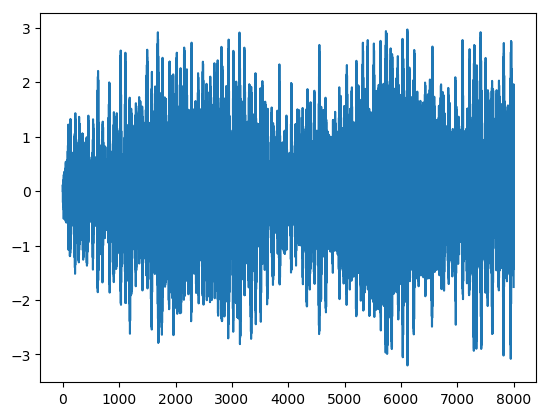

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000129B128>

In [13]:
plt.plot(xif)

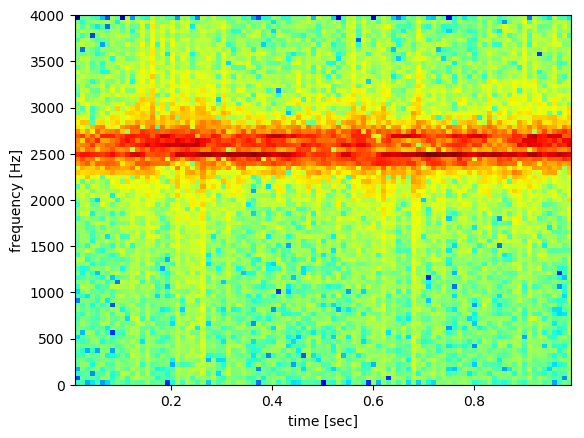

In [14]:
plot_spectrogram(spectrogram(xif, 160, 80, fs=fs_desired), fs_desired)


In [15]:
audioplayers(xif, fs=8000)

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AAAAAAAAtkTrPfw7fD3Bk1a+oGH3PcPGLz1LypG+sQWgPQCM9z2Tywm+jiIgvGpZiz3FPce9PAJdPC0W772cvY8931BVPnlcAr9BRpk+UjB4PndCsr58wBA+VN6BPg3unr7YNa08boSiPpdslL4xgDi+voC1PqoHZb0Wh3q+UuVFPg7PgT5x6my+KZ/1vXykOT5GFxu99zkgvt9hlj5Fe5Y9Ebucvgkwcj1V3Gs+sSpsvvPR7z0BMMw9BGWGvgcd8jxR54c+3r+ivdo/Xr59ltc+7fuWvdzbDL8I8wk/qVhVPb2YDr9iKgQ/mlDbPe3JEr8c2AI/0ZroPUPrBb9NwAQ/SpIIvTJDE7+51MQ+n4k8PpUB7b4VoJg+aoQwPp036L5iaYE91phOPvVZzb2zNbm9lDJ2PRxIwz2tts+9BqlWPECtsj0xjIG9T0movZlTuz6Vc22+JBGIvrmUEj8IgaG+GGCYvliZOz+bF6K+ddHHvgh4Vj+a5aW+AX84vwtmhz+jiUm+lSyEv1Y0nD9CMze+tAqGv0ohcD+RtgM+5GuKv+CVYz9TeX0+kGVZv4KP0T4NNNo+e6kRvztx0rw+1sE+UjVcvk1Hj75rYRA+3RbQPm1pwb6zUhe+kYQuP0axLb6h9Q6/JYZUP2fLCz3DgH6/V+hMP8uEuj72xpi/nBosPyztKD9P0Ji/cFRtPomIgz9PwpG/962RPQ0Akz8i94e/lvCuvud7qT9Ixke/TzkKv2bSnT9dfhS/uysiv0EAkD+eKam+Zfg9v+kBMT8Uago+y6NLv929yz77BAU/TUclv85xEL2k5LI+pMxbvluqur1QjaE+Ec+OO15HhL7Ip4c+ggg8Ps3HFL9wHkE+aLr3Pn+eG78mw9C9c6QCP/q0tb5XOr69ti0JP8lv2b5JQMm9Nf7tPpffqr47VU69isKePviGKL6IG3e+ZwOiPk3LD778+Ka9nsgTP3yaD7+NR02+kLsgP8Wslb4G9L2+xak1P+w/l77zMeS+0FMWP510qLxNCyK/ilbxPqP4fT6vxAm/jdlJPtmbsT7GA5i+fPBlvpkUYj7N5nO91Zk1vt3iOz4Z+7I+Ue+TvrPbmb4Ntxw/3yRFvt2aT7+MRIE/hSJIPVFpnL//7IY/wd6aPpjQs7+LjV0/tyJYP0Bhwr9g88c+2hmiP8+prb/NMOC+zwm3P/a4a7/jzxq/Tl+oPzm13r4ptVO/OBtkP/w5JT7W6nS/kFICP+CIDD9pIFC/fvxNPSX0cz97HyC/Qaf4vryyZT+HeYS+BmYiv79xUz/ncqe9cJo9vwE9DT+mHGs+H7QTv+zuXT51Oqo+PTntvkfKcr2bWs4+JWr6vezWpr6nIV4+npzQPbwWu75lo4U+EKqwPjnb1b4fe06+DIcBP2RrmL54Zm6+vWkKPyz6+722J9u+KhvTPmVOAr4Mvr2+j2XGPnnJBL43KLm+j4IUP/jpizqhWR+/PkxGP72Xqz2VTmG/MPo/P29FzT5R4KK/3p0cP52SKT+wfae/1EqZPrQ5bj/Lx5a/3mq+PX53rj/nR4q/uipsvuOxnj9H11+/w2Edv2Vpnj/tPxm/YBUvv9khjT/KAq++CERrv8ENZz9IT1U9GOd4v3AbDT/7ZRQ/nwRovyhQZT4yO2A/WAJJv6kJXb4lDm8/FVu5vrRJCr9EMU8/y0EWvX9FRr8w3CE/EA+TPtMUZL84y/U+8DEIP8u/Yr/pHmc+yTcQP8UsI79Y6Ks88hAZP0aZlb4wfa++1DvnPqfrmT3U7Yq+6pgFvhRguD7Gdlu9R/O/voY4mD6T+0g+6n0Iv2EnhT7UmeM+Omwjv5ffTj1ciD4/uRNBv7QNWr5go4c//bcdv1hED79Fk4Y/niHMvs/mQb/1eIM/htmjvSPpir+CuFo/Za2HPuXGi797ukc/s/oKP807ob+qMho/16tQP9CCm7+Zx7E+SlJmPypDjb9jcHU+W9s1P2yAV7/tg7A9AzVQP44pUL+7LyE9FCY1P+XYQr+o9ZA8jwceP1FmF7/XzTA+gaDfPtZ4DL8WUs08G7fePr0xEb8LNXs+IV46PrUq7L6O5so+hfgePowsyr7eoIo+yKczviTsG76WA9M+5BqsvrtNX75ZbwE/HrRzvl7fWr4vGBU/9jKNvjs4vL4LVi8/HACBvRPAF7/BGP0++CGDPeA45L6eE5k+4lzKPhRtGr8qOls+zw0cPzJJNr8jf/a91cxiP+uwvL4pXiW/cWF1PyVVpr0bpIy/Gfx8P0QPlz5Qd6i/CtxRPxSYFj8+Ta+/UpkfP6rdTz+Ceau/96a9PhdbYz9va4+/rNIHPjwuST9Z7jW/GcIePO4R4T7tBbe+v0H6PROGgr1xbMa9+W2RPouh477yZfW7pwFLPxxaVr8J3G29reCPP56jZr9NpYm+SkixPyXScL/5qJW+NAmlPzjlQL+Kgwe/aHSZP6yX+L5RyhC/JfdOPynvXr7T58a+Kz0XP6DQ/70KZoW+aSPvPg+vVr6F7C29Xt3RPjR0vr6kiqm9/0nOPn7Dk75ikzS+eXjZPohDgb7OXuq9nHKoPqZGmr7ywEQ9EKhwPlLrRr5A0QK9jtXlPcVHLr66kro9pl+gvE6wyL3W844+m1Vqu76QP77XOVc+nLqKu+Jsh74qOZs+6xqou7KNyr4mCsw+05o/vdrfwL4q2+Y+WjtdPWTVD7+qtQ4/JbtvvqlADb+btwo/d1SdPKvZAL8gzB8/qKLwO99uFL+a1NU+1ZdUPGH5pL52NF4+ZDoSvgkbUT0nABw+glH0vpUtfT6vPmc+JeAwv+st1z69g/g+ZYN2vx0vxj5yKzY/CvWbvwvewT5NRXI/7JO4v0/MXTz7tag/FFCfv6C1C77uQJ4/x451vxX1RL4bapM/9m5Iv2XtMr4qVVs/HHIJv15Yd76Djh8/pI7ovkIt1r0PDxo/t9S0vmHfAL15O7o+dPzsvgqmKz52gBw+n2T2vqrGrT6hljc9AJZ/vkzHmj7XDYi8AUDIvhYfsz5MvU++5T0yvssdAD+jM5C+DeS2vm9lFj9A64W+I4uvvq0aHz8iALO9NQbRvuULDz+6K/+9XhTUvpqz8z5Dwhs97XPmvsPVsD65/dw9ZYojvwtUpj5kQ5s+3Ogbv9Sz2j55uYU9m9vwvlMMtz5i9kQ9dVvPviDctj4lzno+WFP1vi6PnjwozOA+xnrBvh8iZb4so9I+wMaPvWlC6b7hWYg+5gzdPiub477pVlq+wO0wPwZO0b4tRES/PbZzP6oOgT6ArK2/AH9xP4tebj875+O/uDCsPu9h7T+1oO2/2OLZvkl0BkALIqO/DzCSvyAoDUBfVxe/usrRvw6eAkC09cu9nka6v2EcoT+uLS0+IKGwv8yegj+nWuk+2cKVv3xDNT9J8/I+JNl8v9Aylj4oUQY/g+Imvzvykj2m3w4/tDfpvsHEaL5G3MI++aDbvRFalb7V1Sy93IK5PnpQCr51KAO/AkkHP+i9Bz5jh1q/y6RKP5pMQT62BHS/nM9HP64gqj7Y6Yi/orAEP25UCz/mUJS/XKfePh86Vj9lxm6/b8Q1Pr29ID/B5Ue/EE0HPgZp4D7buAe//qQzPqzSij6vbei+ol0APvi7lD6x7QC/eKWQPuNBMj5sBK++bTedPWeW2z0jZJG9c01Gvs1tUj6c7FQ+xIjlvgEaMb6/+SU/j3Xgvgff7L7qoHM/WIdmvWaiWL+hplI/R5S3PmXWu78lhjw/c2p6P0+u1r+wohI/OBqLPxAryL9kYJw+sCKjP9fwur+sEIo83QqeP665mr9DT8i9HcmVP9RIf79s8ea9W1FlP91NQr8qG4c9TdlCP+IbH7+HKEW8nUbpPnZz776zt

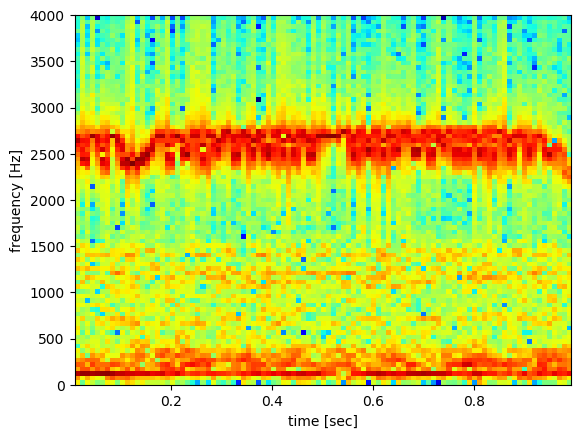

In [16]:
plot_spectrogram(spectrogram(ymix, 160, 80, fs=fs_desired), fs_desired)


## Perform source separation

In [17]:
function observation_model(k, nr_comps, bufsize)
    
    # create factor graph
    fg = FactorGraph()
        
    # create models and combine
    for ki = 1:k
        
        # create signal model
        model = signal_model(ki, nr_comps, bufsize)
        eval(model)
        
    end
    @RV xtot = sum([vars[pad(:x, ki)] for ki=1:k])
    
    # add observation noise
    @RV y ~ GaussianMeanPrecision(xtot, placeholder(:γ_meas, dims=(bufsize,bufsize)))
    
    # create output samples
    placeholder(y, :y, dims=(bufsize,))
    qi =  vcat([[vars[pad(:s,ki)], vars[pad(:smin,ki)], vars[pad(:ρ,ki)], vars[pad(:w,ki)]] for ki = 1:k]...)
    qids = vcat([[pad(:s,ki), pad(:smin,ki), pad(:ρ,ki), pad(:w,ki)] for ki = 1:k]...)
    
    q = ForneyLab.PosteriorFactorization(qi..., ids=qids)
    
    return fg, q
    
end
;

In [18]:
# convert parameters
paramsc = convert_parameters(params)

# load graph
fg, q = observation_model(length(sound_files), 2*nr_freqs, bufsize)

# create algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))

# create arrays for current estimates
data = Dict()
data[:γ_meas] = γ_meas_sep*Ic(bufsize)

# get dictionary of currently inferred values 
vals = Dict()
for k= 1:length(sound_files)
    vals[pad(:μ_smin,k)] = 10*ones(2*nr_freqs)
    vals[pad(:Σ_smin,k)] = 0.001*Ic(2*nr_freqs)
    vals[pad(:μ_ρ,k)] = paramsc[pad(:μ_ρ,k)]
    vals[pad(:Σ_ρ,k)] = paramsc[pad(:Σ_ρ,k)]
    vals[pad(:v_w,k)] = paramsc[pad(:v_w,k)]
    vals[pad(:nu_w,k)] = paramsc[pad(:nu_w,k)]   
end
    
# get signals
signal_s = [ymix[k:k+bufsize-1] for k=1:length(ymix)-bufsize+1]
t_s = [t_sep[k:k+bufsize-1] for k=1:length(t_sep)-bufsize+1]

# separated signals
μ_separated = Array{Array{Float64,1},1}(undef, length(sound_files))
σ_separated = Array{Array{Float64,1},1}(undef, length(sound_files))
for k = 1:length(sound_files)
    μ_separated[k] = Array{Float64,1}(undef, length(ymix))
    σ_separated[k] = Array{Float64,1}(undef, length(ymix))
end

p = Progress(length(signal_s))

# loop through signal
for n = 1:length(signal_s)
       
    # fill data dictionary
    data = merge(data, vals, Dict(:y => signal_s[n].-mean(signal_s[n])))
    for k = 1:length(sound_files)
        data[pad(:C,k)] = reshape([cos.(2*pi*paramsc[pad(:f,k)]*t_s[n]') sin.(2*pi*paramsc[pad(:f,k)]*t_s[n]')]', bufsize, 2*nr_freqs)
    end
    
    # create marginals dictionary
    marginals = Dict()
    for k = 1:length(sound_files)
        marginals[pad(:smin,k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=vals[pad(:μ_smin, k)], v=vals[pad(:Σ_smin, k)])
        marginals[pad(:ρ,k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=vals[pad(:μ_ρ, k)], v=vals[pad(:Σ_ρ, k)])
        marginals[pad(:w,k)] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=vals[pad(:v_w, k)], nu=vals[pad(:nu_w, k)])
    end
    
    # perform updates
    for _ = 1:iterations

        # perform inference
        marginals = Base.invokelatest(getfield(Main, Symbol("steps_01!")), data, marginals)
        for k = 1:length(sound_files)
            #marginals = getfield(Main, Symbol("stepsmin_"*string(k,pad=2)*"!"))(data, marginals)
            #marginals = getfield(Main, Symbol("stepρ_"*string(k,pad=2)*"!"))(data, marginals)
            #marginals = getfield(Main, Symbol("stepw_"*string(k,pad=2)*"!"))(data, marginals)
        end
        #println(ForneyLab.unsafeMean(ruleVariationalARFBOutNPPP(nothing, marginals[:smin_01], marginals[:ρ_01], marginals[:w_01]).dist))
    end

    # get new values
    for ki = 1:length(sound_files)
        vals[pad(:μ_smin, ki)] = ForneyLab.unsafeMean(marginals[pad(:s, ki)])
        vals[pad(:Σ_smin, ki)] = ForneyLab.unsafeCov(marginals[pad(:s, ki)])
    end
    
    # get separated signals
    for ki = 1:length(sound_files)
        C = reshape([cos.(2*pi*paramsc[pad(:f,ki)]*t_s[n]') sin.(2*pi*paramsc[pad(:f,ki)]*t_s[n]')]', bufsize, 2*nr_freqs)
        μ_separated[ki][n] = (C*vals[pad(:μ_smin, ki)])[end]
        σ_separated[ki][n] = (C*vals[pad(:Σ_smin, ki)]*C')[end,end]
        #μ_separated[ki][n] = vals[pad(:μ_smin, ki)][end]
        #σ_separated[ki][n] = sqrt(ForneyLab.unsafeCov(marginals[pad(:s, ki)])[end,end])
    end
    
    next!(p)
end    

Progress: 100%|█████████████████████████████████████████| Time: 0:12:23m%|████████████████████████████████         |  ETA: 0:02:50


## Analyze results

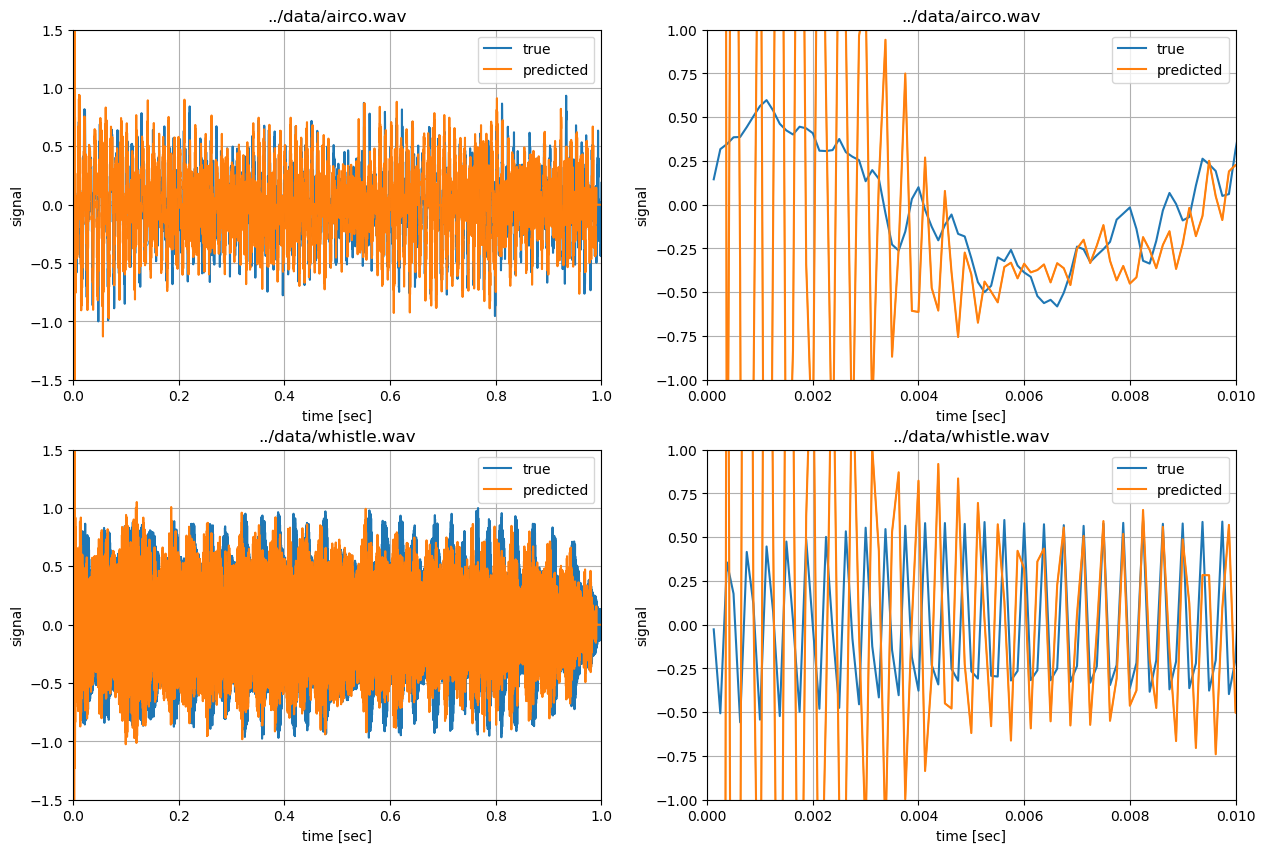

In [19]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t_sep, signal_sep[k], label="true")
    ax[k,1].plot(t_sep, μ_separated[k], label="predicted")
    ax[k,2].fill_between(t_sep, μ_separated[k] .- σ_separated[k], μ_separated[k] .+ σ_separated[k], alpha=0.3, color="orange")
    ax[k,1].set_xlim([0, duration_sep]), ax[k,1].set_ylim([-1.5, 1.5]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k]), ax[k,1].legend()
    
    # plot zoomed-in version of signal
    ax[k,2].plot(t_sep, signal_sep[k], label="true")
    ax[k,2].plot(t_sep, μ_separated[k], label="predicted")
    ax[k,2].fill_between(t_sep, μ_separated[k] .- σ_separated[k], μ_separated[k] .+ σ_separated[k], alpha=0.3, color="orange")
    ax[k,2].set_xlim([0.0, 0.01]), ax[k,2].set_ylim(-1,1), ax[k,2].set_xlabel("time [sec]"), ax[k,2].set_ylabel("signal"), ax[k,2].grid(), ax[k,2].set_title(sound_files[k]), ax[k,2].legend()

end

# save figure
#filename_figures1 = folder_figures*"/PPV_time_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", γ_meas_sep)*".png"
#plt.savefig(filename_figures1)

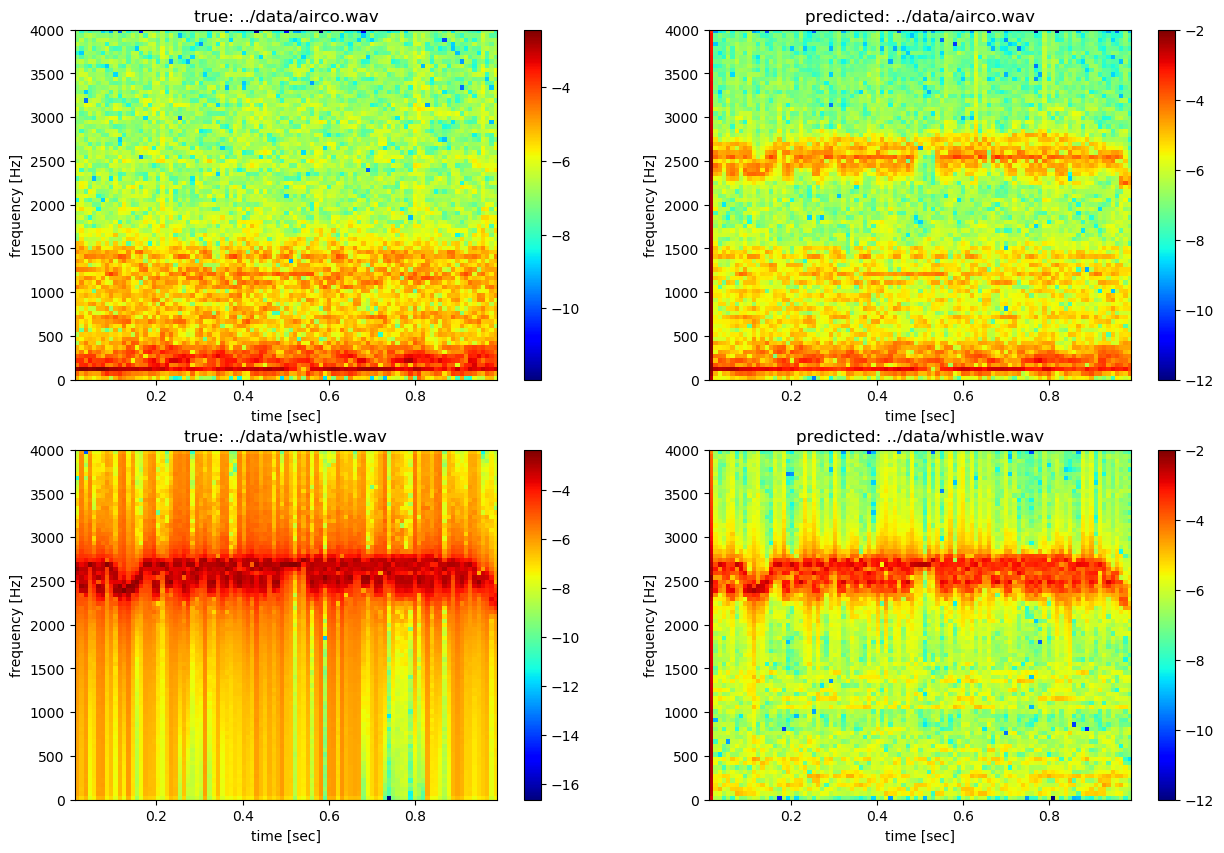

In [20]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot true spectrogram
    plot_spectrogram(spectrogram(signal[k], 160, 80, fs=fs_desired), fs_desired, ax=ax[k,1], colorbar=true)
    ax[k,1].set_title("true: "*sound_files[k])
    
    # plot predicted spectrogram
    plot_spectrogram(spectrogram(μ_separated[k], 160, 80, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true)
    ax[k,2].set_title("predicted: "*sound_files[k])
    ax[k,2].get_images()[1].set_clim(-2, -12)

end

# save figure
#filename_figures2 = folder_figures*"/PPV_freq_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", γ_meas_sep)*".png"
#plt.savefig(filename_figures2)